<a href="https://colab.research.google.com/github/MichalZienkowicz/BirdNET-model-evaluation/blob/main/BirdNET_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Libraries and dependencies

In [105]:
!pip install pydub birdnetlib birdnet

In [106]:
import os
from pydub import AudioSegment
import pandas as pd
from pathlib import Path
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from birdnet import SpeciesPredictions, get_species_from_file, predict_species_within_audio_file
import re
import matplotlib.pyplot as plt
from datetime import datetime
import math
from collections import defaultdict
from itertools import product
from google.colab import drive
import shutil

## Root directory setup


In [107]:
root = '/content/drive/MyDrive/Colab_Notebooks/BirdNET_testing' #change to your Google Drive directory
root_path = Path(root)

## Mounting Google Drive

In [108]:
drive.mount('/content/drive')
os.chdir(root_path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BirdNET_model_evaluation.ipynb	labels_from_files.xlsx	reports_summary.xlsx
Data_converted			labels_scientific.xlsx
Examples			Reports


Following elements should be listed:


*   Data_converted (a directory with 2 database directories)
*   BirdNET_model_evaluation.ipynb (this file)
*   labels_scientific.xlsx (manually filled label file, more on that in this code section: https://colab.research.google.com/drive/1aDMvhqNdozDXeKLkxBkMJxEcmo29xTvi?authuser=2#scrollTo=IeoZgSVL6QP9&line=1&uniqifier=1)



Expected file structure before running the model
```
root_path/     <- project directory on Google Drive
├── BirdNET_model_evaluation.ipynb
├── labels_scientific.xlsx
├── Data_converted/
│   ├── Data_UFT_mono/
│   │   ├── 033 A Kapturka/
│   │   │   ├── Etykieta Utworu.txt
│   │   │   └── VOC_140120-0033-Kapturka.wav
│   │   └── ... (other recording subfolders)
│   └── Data_with_missing_labels/
│       └── 046 A Zaganiacz/
│           └── VOC_140120-0046_zaganiacz.wav
```

# Data preprocessing

### The database directory

In [109]:
data_directory_path = root_path / "Data_converted/Data_UFT_mono" # for the provided files, in presented structure,
# may require a change while working with own dataset

Data used for the program has to contain mono audio files and labels (as well as the additional descriptions) written in a format readable by Python.

Text files had to be manually converted to the UTF format. In case of the DB containing stereo files, function below can convert the files to a mono format.

### Converting audio from stereo to mono

In [110]:
def convert_audio_to_mono(folder_path: str | Path, overwrite: bool = True):
    """
    Creates mono files from all the stereo audio files within the directory and subdirectories.

    Args:
        folder_path (str | Path): Path to the data base folder.
        overwrite (bool): If false, write mono files as new files with "_mono" suffix.
    """
    supported_extensions = (".wav") # only .wav files are analyzed

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(supported_extensions):
                full_path = os.path.join(root, file)
                audio = AudioSegment.from_file(full_path)

                if audio.channels == 1: # skip the file if already mono
                    continue

                mono_audio = audio.set_channels(1)

                if overwrite:
                    # overwriting existing audio files as mono
                    mono_audio.export(full_path, format=file.split('.')[-1])
                else:
                    # creating new files with the "_mono" suffix
                    name, ext = os.path.splitext(file)
                    new_path = os.path.join(root, f"{name}_mono{ext}")
                    mono_audio.export(new_path, format=ext.replace('.', ''))

convert_audio_to_mono(data_directory_path, overwrite=True)

### Reading labels from files

Creating excel spreadsheet containing timestamps, labels and additional information based on provided data base files. Scientific names (later used as labels) have to be **manually inserted into column 6 (F) by user**.

In [111]:
def export_labels_to_excel(audio_root_folder: str | Path, name_of_txt_label_files: str, excel_output_path: str | Path = './labels.xlsx'):
    """
    Scans the root_folder for subfolders containing a file named "Etykieta Utworu.txt"
    and optionally another .txt file with notes.

    For each timestamp entry in "Etykieta Utworu.txt" (a file provided in the DB), it collects:
      - folder: name of the subfolder
      - start: start time (float, in seconds)
      - end: end time (float, in seconds)
      - label: label text from the file
      - notes: content of an additional .txt file, included only in the first row for each folder

    The collected data is saved to an Excel file (default is "./labels.xlsx" unless specified).

    Args:
        audio_root_folder (str | Path): Path to the root folder with audio subfolders.
        name_of_txt_label_files (str): Name of file containg true labels, should be the same for every audio subfolder.
        excel_oytput_path (str | Path, optional): Path to the output Excel file.

    """
    rows = []

    for entry in os.scandir(audio_root_folder):
        if not entry.is_dir():
            continue
        subfolder = entry.name
        subfolder_path = entry.path

        label_path = os.path.join(subfolder_path, name_of_txt_label_files)
        # skip if no label file found
        if not os.path.isfile(label_path):
            continue

        # find optional notes file (any other .txt)
        notes = ""
        for fn in os.listdir(subfolder_path):
            if fn.lower().endswith(".txt") and fn != name_of_txt_label_files:
                with open(os.path.join(subfolder_path, fn), "r", encoding="utf-8") as f:
                    notes = f.read().strip()
                break

        # read label entries
        with open(label_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            start_s = float(parts[0].replace(",", "."))
            end_s   = float(parts[1].replace(",", "."))
            label   = parts[2]
            row = {
                "folder": subfolder,
                "start":  start_s,
                "end":    end_s,
                "label":  label,
                "notes": notes if i == 0 else ""
            }
            rows.append(row)

    df = pd.DataFrame(rows, columns=["folder", "start", "end", "label", "notes"])
    df.to_excel(excel_output_path, index=False)

In [112]:
labels_excel_file_path = root_path / "labels_from_files.xlsx"
name_of_txt_label_files = "Etykieta Utworu.txt"
export_labels_to_excel(data_directory_path, name_of_txt_label_files, labels_excel_file_path)
print(f"Excel saved to: {labels_excel_file_path}")

Excel saved to: /content/drive/MyDrive/Colab_Notebooks/BirdNET_testing/labels_from_files.xlsx


A sheet with species scientific names should be manually created (here it was saved as labels_scientific.xlsx)

In [113]:
labels_scientific_path = root_path / "labels_scientific.xlsx"

### Creating the true labels .txt file for each audio file

In [114]:
def read_true_labels_for_each_file(excel_path: str | Path, time_step_seconds: int = 1) -> dict:
    """
    Loads the labels Excel sheet and creates a dictionary of per-second labels for each folder.

    Args:
        excel_path (str | Path): Path to the .xlsx file with the following columns:
            0: folder_name,
            1: start (float),
            2: end (float),
            3: label (string),
            5: additional description - if available (string),
            6: scientific name label (string).
        time_step_seconds (int): Step size in seconds. Lebels are created over each step.

    Returns:
        dict: {folder_name: {second: [labels...], ...}, ...}
    """
    df = pd.read_excel(excel_path)
    cols = df.columns
    file_col, start_col, end_col = cols[0], cols[1], cols[2]
    label_col = cols[5] if len(cols) >= 6 else cols[3]  # use manual_label if present

    true_labels = {}
    for folder_name, group in df.groupby(file_col):
        per_second = defaultdict(set)
        for _, row in group.iterrows():
            start = float(row[start_col])
            end = float(row[end_col])
            label = str(row[label_col]) if not pd.isna(row[label_col]) else "unspecified"
            for t in range(int(math.floor(start)), int(math.ceil(end)), time_step_seconds):
                per_second[t].add(label)
        true_labels[folder_name] = dict(per_second)

    return true_labels

def create_complete_labels_txt(true_labels: dict, audio_file_path: str | Path, output_dir: str | Path, time_step_seconds: int = 1):
    """
    Generates a text file with per-second labels for a given audio file.

    Args:
        true_labels (dict): Output from get_true_labels_for_each_file.
        audio_file_path (str | Path): Path to the .wav file.
        output_dir (str | Path): Path to the output folder for the .txt file.
        time_step_seconds (int): Step size in seconds.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    audio = AudioSegment.from_file(audio_file_path)
    duration_s = int(math.ceil(audio.duration_seconds))

    folder_name = Path(output_dir).name
    labels_map = true_labels.get(folder_name, {})

    out_path = Path(output_dir) / f"true_{folder_name}.txt"
    with out_path.open("w", encoding="utf-8") as f:
        for t in range(0, duration_s, time_step_seconds):
            start, end = float(t), float(t + time_step_seconds)
            labels = labels_map.get(t, [])
            label_line = ",".join(labels) if labels else "unspecified"
            f.write(f"{start:.1f}-{end:.1f}\t{label_line}\n")

def get_audio_subfolders(audio_root_folder: str | Path) -> list:
    """
    Returns a list of subfolders that contain .wav files.

    Args:
        audio_root_folder (str | Path): Path to the root folder with audio subfolders.

    Returns:
        list: List of Path objects representing subfolders with .wav files.
    """
    root = Path(audio_root_folder)
    return [
        sub for sub in root.iterdir()
        if sub.is_dir() and any(f.suffix.lower() == '.wav' for f in sub.iterdir() if f.is_file())
    ]

def process_files_to_create_true_labels(audio_root_folder: str | Path, excel_path: str | Path, time_step_seconds: int = 1):
    """
    Main function: loads labels from Excel and generates .txt label files in each subfolder containing a .wav file.

    Args:
        audio_root_folder (str | Path): Root directory containing audio subfolders.
        excel_path (str | Path): Path to the Excel file with labels.
        time_step_seconds (int): Step size in seconds.
    """
    true_labels = read_true_labels_for_each_file(excel_path, time_step_seconds)
    for folder in get_audio_subfolders(audio_root_folder):
        for wav_file in folder.glob('*.wav'):  # in practice it should be just one file per folder
            create_complete_labels_txt(true_labels, str(wav_file), str(folder), time_step_seconds)

In [115]:
# creating a copy of the DB directory in which new label files and later model predictions will be written
data_directory_processing_path = root_path / "Data_converted/Data_UFT_mono_for_processing"
# if data_directory_processing_path.exists():
#     shutil.rmtree(data_directory_processing_path) # remove the directory first first to make a clean copy
# shutil.copytree(data_directory_path, data_directory_processing_path)

# creating true label txt files, named true_{directory_name}
process_files_to_create_true_labels(data_directory_processing_path, labels_scientific_path)

# BirdNET analyzer model evaluation

### List of species labeled in a provided data base

In [116]:
all_species = [
    "Sylvia atricapilla",
    "Erithacus rubecula",
    "Phylloscopus collybita",
    "Fringilla coelebs",
    "Troglodytes troglodytes",
    "Oriolus oriolus",
    "Parus major",
    # "Hippolais icterina", # file in the data base has no true labels
    "Phasianus colchicus",
    "Acrocephalus arundinaceus",
    "Turdus philomelos",
    "Phylloscopus sibilatrix",
    "Emberiza citrinella",
    "Phylloscopus trochilus"]

## Functions used for dataset processing

### Run model prediction

In [117]:
def predict_with_analyzer(
    mono_audio_path: str | Path,
    overlap: float = 2.0,
    sensitivity: float = None,
    lon: float = None,
    lat: float = None,
    year: int = None,
    month: int = None,
    day: int = None,
    min_conf: float = None,
):
    """
    Runs an analysis on a mono audio file using the Analyzer and returns the detections.

    Args:
        mono_audio_path (str | Path): Path to the mono audio file.
        overlap (float, optional): Overlap in seconds between analysis windows. Default is 2.0.
        sensitivity (float, optional): Sensitivity setting for the analyzer.
        lon (float, optional): Longitude of the recording location.
        lat (float, optional): Latitude of the recording location.
        year (int, optional): Year of the recording date.
        month (int, optional): Month of the recording date.
        day (int, optional): Day of the recording date.
        min_conf (float, optional): Minimum confidence threshold for detections.

    Returns:
        list: A list of detections produced by the analyzer.
    """
    analyzer = Analyzer()

    recording_kwargs = {
        "analyzer": analyzer,
        "path": mono_audio_path,
        "overlap": overlap,
    }

    # include metadata
    if sensitivity is not None:
        recording_kwargs["sensitivity"] = sensitivity
    if lon is not None:
        recording_kwargs["lon"] = lon
    if lat is not None:
        recording_kwargs["lat"] = lat
    if year is not None and month is not None and day is not None:
        recording_kwargs["date"] = datetime(year=year, month=month, day=day)
    if min_conf is not None:
        recording_kwargs["min_conf"] = min_conf

    recording = Recording(**recording_kwargs)
    recording.analyze()
    return recording.detections

# example usage:
mono_audio_path = data_directory_processing_path / "038 A Kapturka (pierwiosnek)/VOC_140120-0038_Kapt_pierw.wav"

example_predictions = predict_with_analyzer(mono_audio_path, overlap=2.0, sensitivity=1.0, lon=20.35161, lat=50.027020, year=2024, month=5, day=1, min_conf=0.1)
print(example_predictions)

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  51 chunks.
analyze_recording VOC_140120-0038_Kapt_pierw.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
16
178 species loaded.
[{'common_name': 'Eurasian Blackcap', 'scientific_name': 'Sylvia atricapilla', 'start_time': 0.0, 'end_time': 3.0, 'confidence': 0.8530714511871338, 'label': 'Sylvia atricapilla_Eurasian Blackcap'}, {'common_name': 'European Robin', 'scientific_name': 'Erithacus rubecula', 'start_time': 0.0, 'end_time': 3.0, 'confidence': 0.1338755190372467, 'label': 'Erithacus rubecula_European Robin'}, {'common_name': 'Eurasian Blackcap', 'scientific_name': 'Sylvia atricapilla', 'start_time': 1.0, 'end_time': 4.0, 'confidence': 0.8986789584159851, 'label': 'Sylvia atricapilla_Eurasian Blackcap'}, {'common_name': 'Eurasian Blackcap', 'scientific_name': 'Sylvia atricapilla', 'star

### Saving the model predictions as .txt files

In [118]:
def save_txt_predictions(predictions: list, output_pred_file_path: str | Path):
    """
    Saves a list of prediction dictionaries to a formatted .txt file inside a 'Predictions' directory.

    Each prediction is expected to include 'start_time', 'end_time', 'label', and 'confidence'.
    If there is a time gap of more than 3 seconds between predictions, "no predictions" lines are inserted.

    Args:
        predictions (list): List of prediction dictionaries.
        output_pred_file_path (str | Path): Output path for saving the predictions.
    """
    #os.makedirs("Predictions", exist_ok=True)
    path = output_pred_file_path# os.path.join("Predictions", output_pred_file_path)

    with open(path, "w", encoding="utf-8") as f:
        previous_start_time = None
        for item in predictions:
            start_time = item['start_time']
            end_time = item['end_time']
            #if int(start_time - previous_start_time > 3 -> insert additional line with "no predictions")
            label_scientific = re.split("_",item['label'])[0]

            if previous_start_time == None:
                if start_time == 0.0:
                    file_segment = f"{start_time:.1f}-{end_time:.1f}\t{label_scientific}\t{item['confidence']:.6f}" # fisrt line
                else:
                    file_segment_no_pred = f"0.0-0.3\tno predictions"
                    previous_start_time = 0.0
                    f.write(file_segment_no_pred)
                    while previous_start_time < start_time - 1:
                        previous_start_time += 1
                        file_segment_no_pred = f"\n{previous_start_time:.1f}-{previous_start_time+3:.1f}\tno predictions"
                        f.write(file_segment_no_pred)
                    file_segment = f"\n{start_time:.1f}-{end_time:.1f}\t{label_scientific}\t{item['confidence']:.6f}"
            elif previous_start_time != start_time:
                while previous_start_time < start_time - 1:
                    previous_start_time += 1
                    file_segment_no_pred = f"\n{previous_start_time:.1f}-{previous_start_time+3:.1f}\tno predictions"
                    f.write(file_segment_no_pred)
                file_segment = f"\n{start_time:.1f}-{end_time:.1f}\t{label_scientific}\t{item['confidence']:.6f}"
            else:
                file_segment = f"\t{label_scientific}\t{item['confidence']:.6f}"
            f.write(file_segment)
            previous_start_time = start_time

def convert_predictions_to_one_second(
    input_predictions_path: str | Path,
    output_prefix: str = "one_sec",
    min_confidence: float = 0.0
):
    """
    Converts 3-second prediction segments into 1-second windows.

    Each time segment is expanded to per-second resolution. If "no predictions" is explicitly present
    or no label reaches the confidence threshold, the second is marked as "no predictions".

    Args:
        input_predictions_path (str | Path): Input file with original predictions.
        output_prefix (str): Prefix for the output file name.
        min_confidence (float): Minimum confidence threshold to include a prediction.
    """
    input_path = Path(input_predictions_path)
    lines = [L.strip() for L in input_path.read_text(encoding="utf-8").splitlines() if L.strip()]

    second_to_labels = {}
    max_sec = 0

    for line in lines:
        parts = line.split('\t')
        if len(parts) < 2:
            continue

        # parse start and end times
        start_f, end_f = map(float, parts[0].split('-'))
        preds = parts[1:]

        # determine the range of segment
        sec_start = int(math.floor(start_f))
        sec_end   = int(math.ceil(end_f))
        max_sec = max(max_sec, sec_end)

        if preds[0].lower() == "no predictions":
            labels = ["no predictions"]
        else:
            labels = []
            # preds: [label1, score1, label2, score2, ...]
            for i in range(0, len(preds), 2):
                label = preds[i]
                try:
                    score = float(preds[i+1])
                except (IndexError, ValueError):
                    score = 0.0
                if score >= min_confidence:
                    labels.append(label)

        # assign labels to each second in the segment
        for sec in range(sec_start, sec_end):
            second_to_labels.setdefault(sec, []).extend(labels)

    out_lines = []
    for sec in range(0, max_sec):
        lab_list = second_to_labels.get(sec, ["no predictions"])
        # remove duplicates while keeping 'no predictions' if it's the only label
        unique = []
        for l in lab_list:
            if l not in unique:
                unique.append(l)
        out_label = ",".join(unique)
        out_lines.append(f"{sec}.0-{sec+1}.0\t{out_label}")

    # save the output
    out_path = input_path.parent / f"{output_prefix}_{input_path.name}"
    out_path.write_text("\n".join(out_lines), encoding="utf-8")

# example usage:
example_files_directory_path = root_path / "Examples"
os.makedirs(example_files_directory_path, exist_ok=True)
example_predictions_path = example_files_directory_path / "example_predictions - 038 A Kapturka (pierwiosnek).txt"
save_txt_predictions(example_predictions, example_predictions_path)
convert_predictions_to_one_second(example_predictions_path) # creates "one_sec_example_predictions - 038 A Kapturka (pierwiosnek).txt"

### Computing metrics for model evaluation

In [119]:
def load_label_map(one_sec_predictions_path: str | Path):
    """
    Reads file labels from .txt file to a dictionary.

    Args:
        one_sec_predictions_path (str | Path): Path to the 1-second labels file.

    Returns:
        label_map (dict): Dictionary mapping second numbers to lists of labels.
    """
    label_map = {}
    for line in Path(one_sec_predictions_path).read_text(encoding="utf-8").splitlines():
        if not line.strip():
            continue
        time_range, labels_str = line.split("\t", 1)
        second = int(float(time_range.split("-")[0]))
        labels = [l.strip() for l in labels_str.split(",")]
        # filter out unwated labels
        labels = [l for l in labels if l not in {"unspecified", "no predictions"}]
        label_map[second] = labels
    return label_map

def compute_detection_metrics(true_path: str | Path, pred_path: str | Path): # to verify if working 100% correctly
    """
    Computes detection metrics by comparing true and predicted labels over 1-second intervals.

    Args:
        true_path (str | Path): Path to the 1-second true labels file.
        pred_path (str | Path): Path to the 1-second predicted labels file.

    Returns:
        tuple: (num_recognitions, true_positive, false_negative)
            - num_recognitions (int): Total number of true labels across all seconds.
            - true_positive (int): Number of true labels that were correctly predicted.
            - false_negative (int): Number of true labels that were missed in predictions.
    """
    true_map = load_label_map(true_path)
    pred_map = load_label_map(pred_path)

    all_seconds = set(true_map) | set(pred_map)
    num_recognitions = true_positive = false_negative = 0

    for sec in sorted(all_seconds):
        true_labels = set(true_map.get(sec, []))
        predicted_labels = set(pred_map.get(sec, []))

        num_recognitions += len(true_labels)
        true_positive += len(true_labels & predicted_labels)
        false_negative += len(true_labels - predicted_labels)

    return num_recognitions, true_positive, false_negative

def compute_detection_metrics_for_specie(true_path: str | Path, pred_path: str | Path, specie: str):
    """
    Computes detection metrics for a specific specie by comparing true and predicted labels.

    Args:
        true_path (str | Path): Path to the true labels file.
        pred_path (str | Path): Path to the predicted labels file.
        specie (str): Scientific name of the specie.

    Returns:
        tuple: (num_recognitions, true_positive, false_negative)
            - num_recognitions (int): Number of times the specie appears in the true labels.
            - true_positive (int): Number of correct detections of the specie.
            - false_negative (int): Number of missed detections of the specie.
    """
    true_map = load_label_map(true_path)
    pred_map = load_label_map(pred_path)

    num_recognitions = 0
    true_positive    = 0
    false_negative   = 0

    # check true labels for every second
    for sec, true_labels in true_map.items():

        if specie not in true_labels:
            continue

        num_recognitions += 1
        preds = pred_map.get(sec, [])
        if specie in preds:
            true_positive += 1
        else:
            false_negative += 1

    return num_recognitions, true_positive, false_negative

# example usage
example_true_path = data_directory_processing_path / "038 A Kapturka (pierwiosnek)/true_038 A Kapturka (pierwiosnek).txt"
example_predictions_one_sec_path = example_files_directory_path / "one_sec_example_predictions - 038 A Kapturka (pierwiosnek).txt"
NR, TP, FN = compute_detection_metrics(example_true_path, example_predictions_one_sec_path)
print("Detection metrics for all species:")
print('\tRecognitions: ', NR)
print('\tTrue positive: ', TP)
print('\tFalse negative: ', FN)

specie = "Erithacus rubecula"
NR, TP, FN = compute_detection_metrics_for_specie(example_true_path, example_predictions_one_sec_path, specie)
print(f"Detection metrics for specie '{specie}':")
print('\tRecognitions: ', NR)
print('\tTrue positive: ', TP)
print('\tFalse negative: ', FN)

Detection metrics for all species:
	Recognitions:  59
	True positive:  29
	False negative:  30
Detection metrics for specie 'Erithacus rubecula':
	Recognitions:  17
	True positive:  1
	False negative:  16


### Saving prediction metrices

In [120]:
def save_report(audio_root_folder: str | Path,
                file_prefix: str,
                NR: int,
                TP: int,
                FN: int,
                Recall: float,
                output_report_path: str | Path = "evaluation_report.txt",
                analyzer_prediction_arg_dict: dict = None,
                specie: str = None):
    """
    Saves an evaluation report summarizing model performance metrics.

    Args:
        audio_root_folder (str | Path): Root directory used during evaluation.
        file_prefix (str): Prefix used to identify prediction files.
        NR (int): Total number of recognitions.
        TP (int): Number of true positives.
        FP (int): Number of false positives (not used in current report content but included for future extensibility).
        Recall (float): Recall metric calculated as TP / (TP + FN).
        output_report_path (str | Path, optional): Path where the evaluation report will be saved. Defaults to "evaluation_report.txt".
        analyzer_prediction_arg_dict (dict, optional): Arguments used during prediction. Defaults to None.
        specie (str, optional): If specified, report is for a specific species.
    """
    report_lines = []
    report_lines.append("Evaluation Report")
    report_lines.append("=================")
    if specie is None:
        report_lines.append("Specie: All")
    else:
        report_lines.append(f"Specie: {specie}")
    report_lines.append(f"File prefix: {file_prefix}")
    if analyzer_prediction_arg_dict is None:
        report_lines.append("Analyzer prediction arguments: None; overlap = 2.0")
    else:
        report_lines.append(f"Analyzer prediction arguments: {analyzer_prediction_arg_dict}")
    report_lines.append("")
    report_lines.append(f"Total recognitions (NR): {NR}")
    report_lines.append(f"True positives (TP):     {TP}")
    report_lines.append(f"False negatives (FN):    {FN}")
    report_lines.append(f"Recall:                  {Recall:.4f}")
    report_text = "\n".join(report_lines)

    with open(output_report_path, "w", encoding="utf-8") as f:
        f.write(report_text)

def summarize_reports_to_excel(report_folder: str | Path, excel_output_path: str | Path):
    """
    Summarizes individual evaluation reports into a single Excel file grouped by overlap and min_conf values.

    Args:
        report_folder (str | Path): Directory containing individual evaluation report text files.
        excel_output_path (str | Path): Path to the Excel file to be created with the summarized results.

    Each report file is expected to follow the naming pattern:
        report_{species}_ov{overlap}_..._conf{min_conf}.txt

    For each report, the following information is extracted:
        - Species name
        - Overlap value (as float)
        - Minimum confidence value (as float)
        - NR (Total recognitions)
        - TP (True positives)
        - FN (False negatives)
        - Recall (TP / (TP + FN))

    Reports are grouped by unique (overlap, min_conf) pairs. Each group is written to a separate
    worksheet in the Excel file. Each worksheet contains:
        - Columns: Species names
        - Rows: Metrics ("NR", "TP", "FN", "Recall")
    """
    report_folder = Path(report_folder)
    reports = list(report_folder.glob("report_*.txt"))

    # regex to extract overlap and min_conf from the filename
    filename_re = re.compile(r"report_.*_ov(?P<ov>[\d\.p]+)_.*_conf(?P<conf>[\d\.p]+)\.txt$")

    # regexes to extract metrics from file content
    nr_re     = re.compile(r"Total recognitions \(NR\):\s*(\d+)")
    tp_re     = re.compile(r"True positives \(TP\):\s*(\d+)")
    fn_re   = re.compile(r"False negatives \(FN\):\s*(\d+)")
    recall_re = re.compile(r"Recall:\s*([\d\.]+)")
    specie_re = re.compile(r"Specie:\s*(.+)")

    data = {}         # dictionary to store parsed results grouped by (overlap, min_conf)
    overlaps = set()  # unique overlap values
    confs = set()     # unique min_conf values

    for rpt in reports:
        m = filename_re.match(rpt.name)
        # skip files that do not match expected pattern
        if not m:
            continue

        # convert overlap and min_conf strings like '2p0' to float 2.0
        ov_str = m.group("ov").replace("p", ".")
        conf_str = m.group("conf").replace("p", ".")
        overlap = float(ov_str)
        min_conf = float(conf_str)
        overlaps.add(overlap)
        confs.add(min_conf)

        text = rpt.read_text(encoding="utf-8", errors="ignore")

        # extract species name from report
        sp = specie_re.search(text)
        species = sp.group(1).strip() if sp else rpt.name

        # extract metrics
        nr = int(nr_re.search(text).group(1))
        tp = int(tp_re.search(text).group(1))
        fn_val = int(fn_re.search(text).group(1))
        rec = float(recall_re.search(text).group(1))

        key = (overlap, min_conf)
        data.setdefault(key, {})[species] = (nr, tp, fn_val, rec)

    # sort overlaps and min_confs for Excel sheet ordering
    overlaps = sorted(overlaps)
    confs = sorted(confs)

    # generate Excel workbook
    with pd.ExcelWriter(excel_output_path, engine="openpyxl") as writer:
        for ov in overlaps:
            for cf in confs:
                key = (ov, cf)
                species_list = sorted(data.get(key, {}).keys())

                # initialize dataframe with metric as rows and species as columns
                df = pd.DataFrame(index=["NR", "TP", "FN", "Recall"],
                                  columns=species_list,
                                  dtype=object)

                # filling in the metric values for each species
                for sp in species_list:
                    nr, tp, fn_val, rec = data[key][sp]
                    df.at["NR", sp] = nr
                    df.at["TP", sp] = tp
                    df.at["FN", sp] = fn_val
                    df.at["Recall", sp] = rec

                # use 'p' instead of '.' in the sheet name, maximum length as 31
                sheet_name = f"ov{ov}_cf{cf}".replace(".", "p")[:31]
                df.to_excel(writer, sheet_name=sheet_name)

def add_all_species_column_to_excel(excel_path: str | Path):
    """
    Adds a new column labeled 'All species' to each sheet in the Excel file.

    The 'All species' column contains the average recall value across all species in that sheet.
    Only the 'Recall' row will have a value in this column; other rows will remain empty.

    Args:
        excel_path (str | Path): Path to the Excel file where the column will be added.
    """
    excel_path = Path(excel_path)
    updated_sheets = {}

    # Read all sheets from the Excel file
    xl = pd.read_excel(excel_path, sheet_name=None, index_col=0)

    for sheet_name, df in xl.items():
        if "Recall" in df.index:
            if "All species" not in df.columns:
                # Calculate mean recall
                mean_recall = df.loc["Recall"].mean(numeric_only=True)

                # Add a new column with NaNs, then assign only recall value
                df["All species"] = None
                df.loc["Recall", "All species"] = mean_recall

        updated_sheets[sheet_name] = df

    # Save the modified sheets back to the same Excel file
    with pd.ExcelWriter(excel_path, engine="openpyxl", mode="w") as writer:
        for sheet_name, df in updated_sheets.items():
            df.to_excel(writer, sheet_name=sheet_name)

# Running predictions on the whole dataset

### Grid evaluation values

In [121]:
sensitivity = 1.0
min_confs = [0.4, 0.1, 0.05]
overlaps = [0.0, 1.0, 2.0]
total_runs = len(overlaps) * len(min_confs)

### Setting up the analysis result file paths

In [122]:
reports_folder_path = root_path / 'Reports'
reports_folder_path.mkdir(parents=True, exist_ok=True)
report_excel_path = root_path / "reports_summary.xlsx"

### Predictions (Warning, long time of calculations)

In [123]:
# for specie in all_species:
#     print(f"Evaluating model for specie: '{specie}'")
#     run_id = 1
#     for overlap, min_conf in product(overlaps, min_confs):
#         print(f"{run_id}/{total_runs} runs for '{specie}'")

#         arg_dict = {
#                 "overlap": overlap,
#                 "sensitivity": sensitivity,
#                 "min_conf": min_conf,
#                 # coordinates (Puszcza Niepołomnicka, Cracow, Poland), and time of data gathering:
#                 "lat": 50.027020,
#                 "lon": 20.351612,
#                 "year": 2024,
#                 "month": 5,
#                 "day": 1
#         }

#         prefix = f"ov{overlap}_sens{sensitivity}_conf{min_conf}".replace(".", "p")
#         report_filename = f"report_{specie}_{prefix}.txt"

#         report_path = reports_folder_path / report_filename
#         subfolders = get_audio_subfolders(data_directory_processing_path)

#         NR = 0
#         TP = 0
#         FN = 0

#         for folder in subfolders:
#             wavs = list(folder.glob('*.wav'))
#             if not wavs:
#                 continue
#             for wav in wavs: # should be just a single file, can be changed later
#                 results_pred_path = Path(folder) / f"{prefix}_{Path(folder).name}.txt"
#                 if arg_dict is not None:
#                     detections = predict_with_analyzer(wav, **arg_dict)
#                 else:
#                     detections = predict_with_analyzer(wav)

#                 save_txt_predictions(detections, str(results_pred_path))
#                 convert_predictions_to_one_second(str(results_pred_path))

#                 pred_path = Path(folder) / f"one_sec_{prefix}_{Path(folder).name}.txt"
#                 true_path = Path(folder) / f"true_{Path(folder).name}.txt"

#                 nr, tp, fn, = compute_detection_metrics_for_specie(true_path, pred_path, specie)
#                 NR += nr
#                 TP += tp
#                 FN += fn

#         Recall = TP / (TP + FN)
#         save_report(audio_root_folder=folder,
#                     file_prefix=prefix,
#                     NR = NR,
#                     TP = TP,
#                     FN = FN,
#                     Recall = Recall,
#                     output_report_path=report_path,
#                     analyzer_prediction_arg_dict=arg_dict,
#                     specie=specie)
#         run_id += 1

In [124]:
summarize_reports_to_excel(reports_folder_path, report_excel_path)
add_all_species_column_to_excel(report_excel_path)

# Results analysis

### Plotting results

In [125]:
def plot_recall_from_summary(excel_path: str | Path, output_dir: str | Path = "recall_plots"):
    """
    Generates bar plots of Recall for each overlap value (ov) from a summary Excel file.
    For each species, the Recall values are plotted for different min_conf (cf) values.
    Keeps the order of species from the Excel file, placing 'All species' last.

    Args:
        excel_path (str | Path): Path to the Excel file created by summarize_reports_to_excel.
        output_dir (str | Path): Directory where the plots will be saved.
    """
    excel_path = Path(excel_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    xls = pd.ExcelFile(excel_path)

    sheet_pattern = re.compile(r"ov(?P<ov>[\d]+p[\d]+)_cf(?P<cf>[\d]+p[\d]+)")
    grouped_data = {}
    species_order_by_ov = {}

    for sheet in xls.sheet_names:
        match = sheet_pattern.match(sheet)
        if not match:
            continue
        ov = match.group("ov").replace("p", ".")
        cf = match.group("cf").replace("p", ".")
        df = xls.parse(sheet)

        # first column is metric, rest are species names
        df = df.set_index(df.columns[0])
        species = list(df.columns)

        species_order_by_ov[ov] = species  # save order
        recall_series = df.loc["Recall"]
        grouped_data.setdefault(ov, {})[cf] = recall_series

    # generate plots per overlap
    for ov, conf_data in grouped_data.items():
        recall_df = pd.DataFrame(conf_data)  # rows: species, cols: confs
        recall_df = recall_df.loc[species_order_by_ov[ov]]

        recall_df = recall_df.astype(float)

        ax = recall_df.plot(kind="bar", figsize=(12, 6))
        plt.title(f"Recall values for different species, overlap = {ov} s")
        plt.xlabel("Species")
        plt.ylabel("Recall")
        plt.ylim(0, 1.05)
        plt.legend(title="min_conf value")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.6)

        plot_file = output_dir / f"recall_overlap_{ov.replace('.', 'p')}.png"
        plt.savefig(plot_file)
        plt.show()

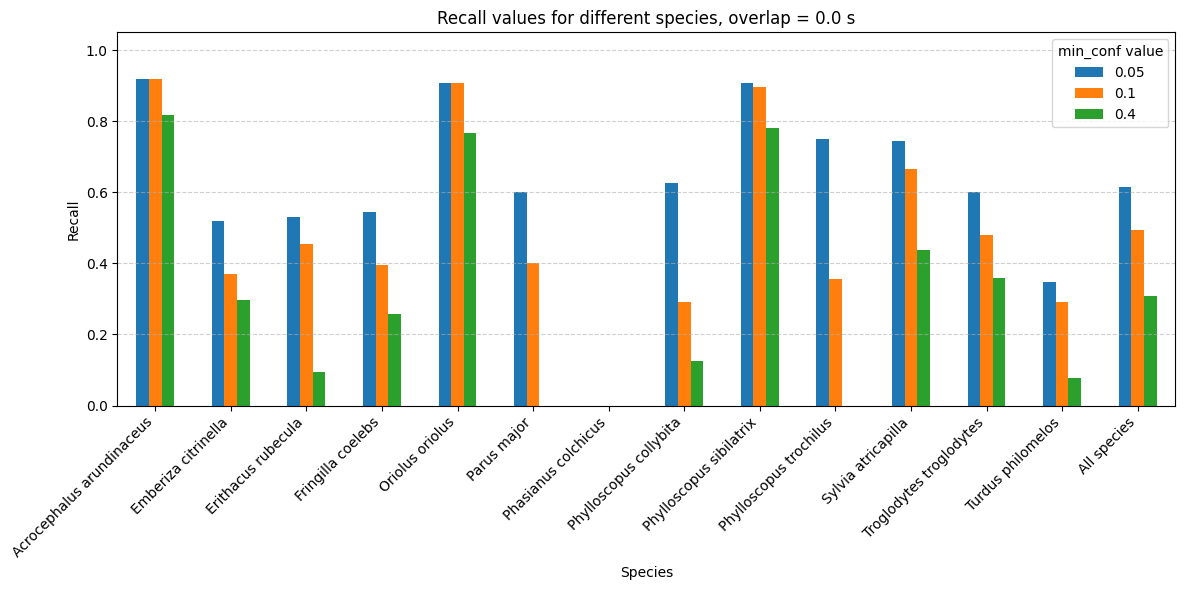

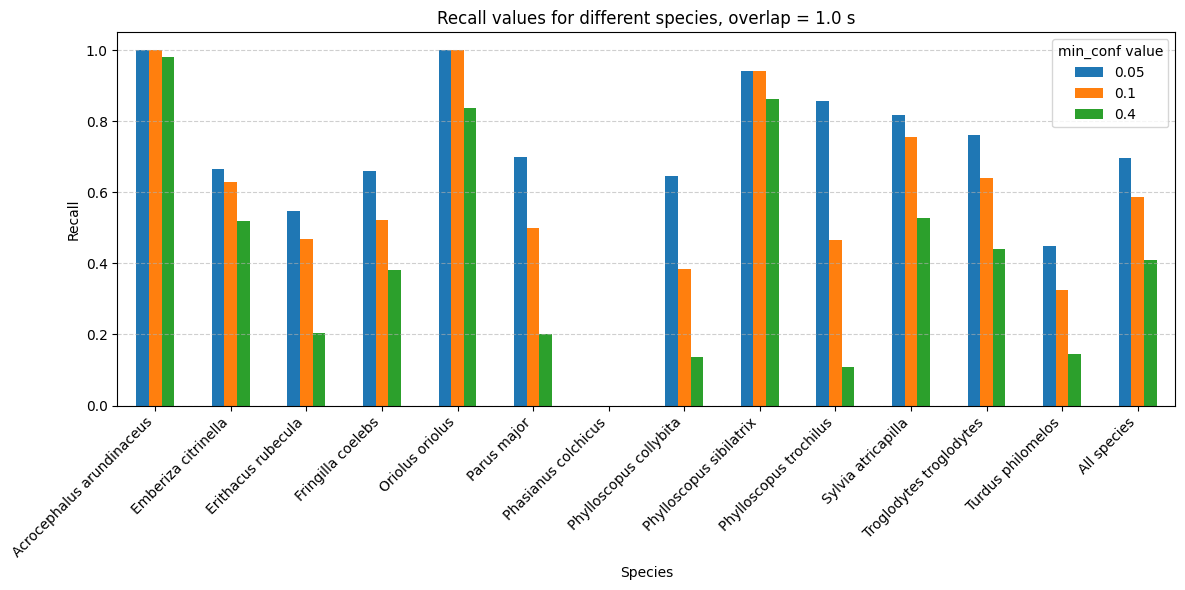

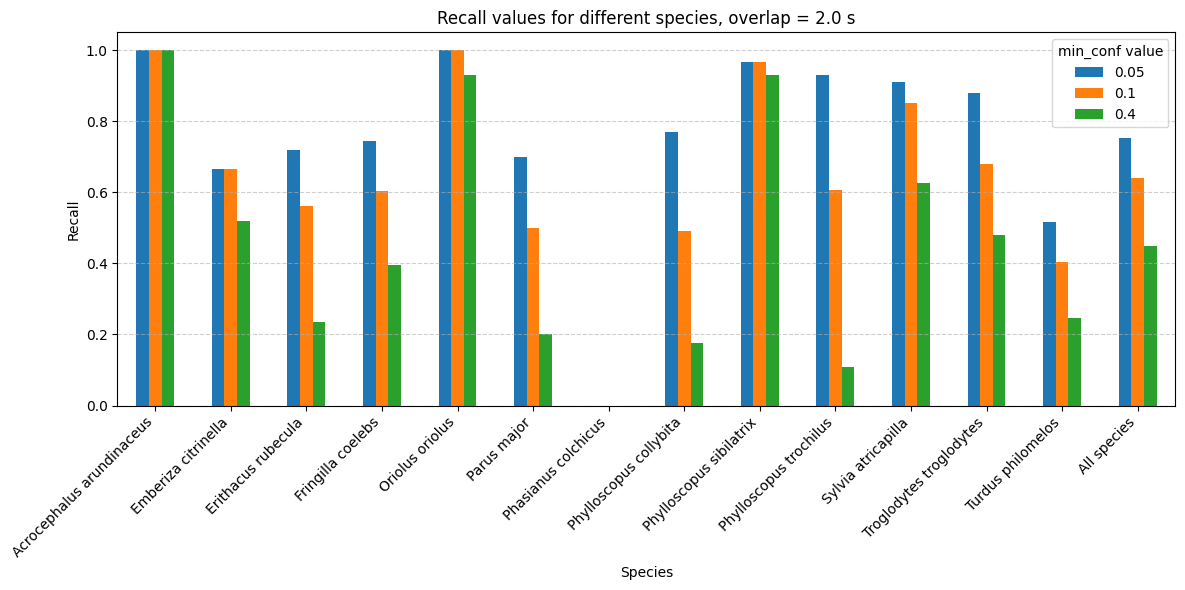

In [126]:
output_fig_path = root_path / "Recall plots"
output_fig_path.mkdir(exist_ok=True)
plot_recall_from_summary(report_excel_path, output_fig_path)

### Plots analysis and conclusions



---


Inability to analyze the number of False Positives (FP - number of incorrect recognitions), reduces the range of possible analysis, as it is not possible to assess how often model is predicting the wrong specie.



---


Analyzing the recall values, it is visible that values vary across the analyzed species, being the highest for Acrocephalus arundinaceus and Oriolus oriolus (reaching up to value of 1.0, the highes possible recall meaning every true vocalisation sample had corresponding model prediction). High values are also achieved for Phylloscopus sibilatrix.



---


It is visible, that for most species, there are some vocalisation samples that are not correcly recognized. Even with high value of overlap (2.0 seconds), which reduces the impact of samples containing fraction of second of vocalisation as well as low confidence required for accepting predictions, model seems to miss the vocalizations in the recording.
This takes place for Phasianus colchicus. This specie had only one vocalisation lasting over 2 seconds. There is not much background noise in the audio corresponding to the vocalisation. Exact reason for model missing some of vocalisations including the one of Phasianus colchicus is unknown, but it makes it clear that further developement of model is necessary for full acurate predictions.



---


Results present, that increasing the overlap values leads to greater recall. While the cost of that improvement is greater calculation time, increasing this value in theory should not increase the ratio of TP/FP ratio, which is expected disadvantage of decreasing the min_conf value. While setting the minimal confidence value low allows for greater recall values, it causes model to produce a lot more false predictions (False Positives). Measuring the impact of decreasing minimum confidence on model accuracy or precision would require fully labeled data, which was not analyzed in this project.


---



Reducing the min_conf has different impact for different species. Recall remains high for Acrocephalus arundinaceus, Oriolus oriolus and Phylloscopus sibilatrix even for minimal confidence set to 0.4. The greatest differences in recall values are present for Phylloscopus trochilus. Due to the impact of possible False Positives caused by the low values of min_conf parameter, the results for high confidence (0.4) may be the most informing, as in this case number of False Positives is most likely reduced. Full evaluation should be conducted with a fully labeled dataset.


---


In conclusion, if increasing calculation time is feasible, increasing the overlap parameter for BirdNET-Analyzer v2.1.0 model is adviced, as it allows to avoid missing recognitions due to vocalisations being cut by windows. Model performs differently for different species in the database - for most species some vocalisations remain unrecognized even with low value of min_conf parameter. While reducing the value of min_conf leads to larger recall, it is expected to cause more false positives, which should be evaluated on fully labeled dataset.

## Cleaning the environment

Expected File structure before after running the model (before optional files deletion):
```
root_path/
├── BirdNET_model_evaluation.ipynb
├── labels_scientific.xlsx
├── labels_from_files.xlsx
├── reports_summary.xlsx
├── Reports/
│   ├── report_Sylvia atricapilla_metadata1.txt
│   └── ... (other report files)
├── Examples/
│   ├── one_sec_example_predictions - 038 A Kapturka (pierwiosnek).txt
│   └── example_predictions - 038 A Kapturka (pierwiosnek).txt
├── Recall plots/
│   ├──recall_overlap_0p0.png
│   ├──recall_overlap_1p0.png
│   └──recall_overlap_2p0.png
├── Data_converted/
│   ├── Data_UFT_mono/
│   │   ├── 033 A Kapturka/
│   │   │   ├── Etykieta Utworu.txt
│   │   │   └── VOC_140120-0033-Kapturka.wav
│   │   └── ... (other recording subfolders)
│   ├── Data_with_missing_labels/
│   │   └── 046 A Zaganiacz/
│   │       └── VOC_140120-0046_zaganiacz.wav
│   └── Data_UFT_mono_for_processing/
│       ├── 033 A Kapturka/
│       │   ├── Etykieta Utworu.txt
│       │   ├── VOC_140120-0033-Kapturka.wav
│       │   ├── true_033 A Kapturka.txt
│       │   ├── metadata1_033 A Kapturka.txt
│       │   ├── one_sec_metadata1_033 A Kapturka.txt
│       │   ├── ... (other metadata labels)
│       │   └── ... (other metadata one_sec labels)
│       └── ... (other processed subfolders)
```

In [127]:
# Define files or directories to clear
flags = {
    "data_directory_for_processing": False,
    "example_files": False,
    "labels_from_files_excel": False,
    "raports": False,
    "raport_summary_excel": False,
    "recall_plots": False
}

paths = {
    "data_directory_for_processing": data_directory_processing_path,
    "example_files": example_files_directory_path,
    "labels_from_files_excel": labels_excel_file_path,
    "raports": reports_folder_path,
    "raport_summary_excel": report_excel_path,
    "recall_plots": output_fig_path
}

# Delete selected files or directories based on flags
for key, should_delete in flags.items():
    if should_delete:
        path = Path(paths[key])
        if path.exists():
            if path.is_dir():
                shutil.rmtree(path)
                print(f"Deleted directory: {path}")
            else:
                path.unlink()
                print(f"Deleted file: {path}")